# CNN models trained for the automated diagnosis of COVID-19

In this notebook I will train many Convolutional Neural Networks to compare and contrast the effects of the data augmentation achieved through the use of multiple Generative Adversarial Networks.  I will also show the data we will be using to train such models and examples of the "fake" data generated through the use of GANs.

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/COVID-19_Radiography_Dataset"

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
 COVID			      Normal.metadata.xlsx
 COVID.metadata.xlsx	      README.md.txt
 Lung_Opacity		     'Viral Pneumonia'
 Lung_Opacity.metadata.xlsx  'Viral Pneumonia.metadata.xlsx'
 Normal


In [49]:
# import packages

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import keras as keras
import numpy as np
import pandas as pd
import matplotlib as plt
import os
chest_xray_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19")
chest_xray_dataset_annotations = os.path.abspath("/content/gdrive/My Drive/annotations")
radiography_dataset = os.path.abspath("/content/gdrive/My Drive/COVID-19_Radiography_Dataset/")
xray_covid19_dataset = os.path.abspath("/content/gdrive/My Drive/xray_dataset_covid19/")

## Listing the files in each datasets directory

As we can see below there are numerous files for each type of category which we will be looking to predict from the patients X-Ray


In [50]:
# may have some issues need to divide into train / test and label
print(os.listdir(chest_xray_dataset))

['test', 'train']


In [51]:
print(os.listdir(radiography_dataset))

['COVID.metadata.xlsx', 'Lung_Opacity.metadata.xlsx', 'Normal.metadata.xlsx', 'Viral Pneumonia.metadata.xlsx', 'README.md.txt', 'COVID', 'Viral Pneumonia', 'Normal', 'Lung_Opacity']


In [52]:
print(os.listdir(xray_covid19_dataset))

['test', 'train']


## Examples of Classes from each dataset

Found 42330 files belonging to 4 classes.
Using 33864 files for training.
Found 42330 files belonging to 4 classes.
Using 8466 files for validation.


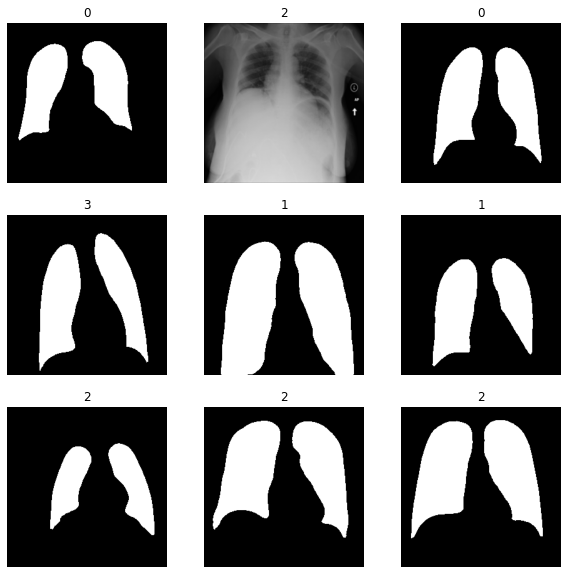

In [54]:
import matplotlib.pyplot as plt
image_size = (256, 256)
batch_size = 128
train_ds = tf.keras.preprocessing.image_dataset_from_directory(radiography_dataset, validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(radiography_dataset, validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

Found 188 files belonging to 2 classes.


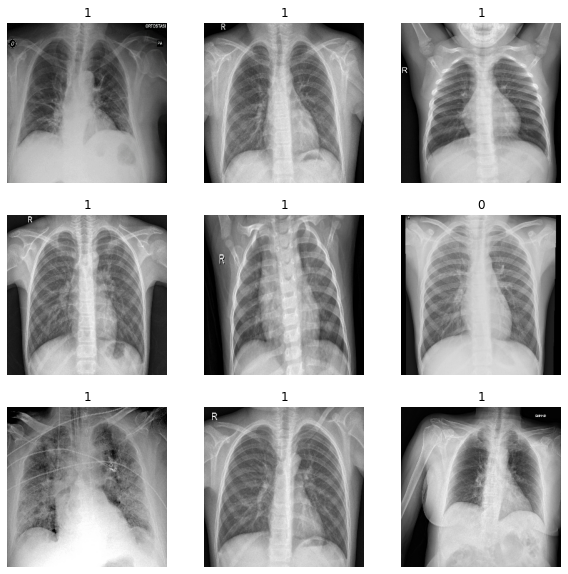

In [ ]:
import matplotlib.pyplot as plt

train_ds = tf.keras.preprocessing.image_dataset_from_directory(xray_covid19_dataset)

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [55]:
!pip install pydot
!pip install graphviz 


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


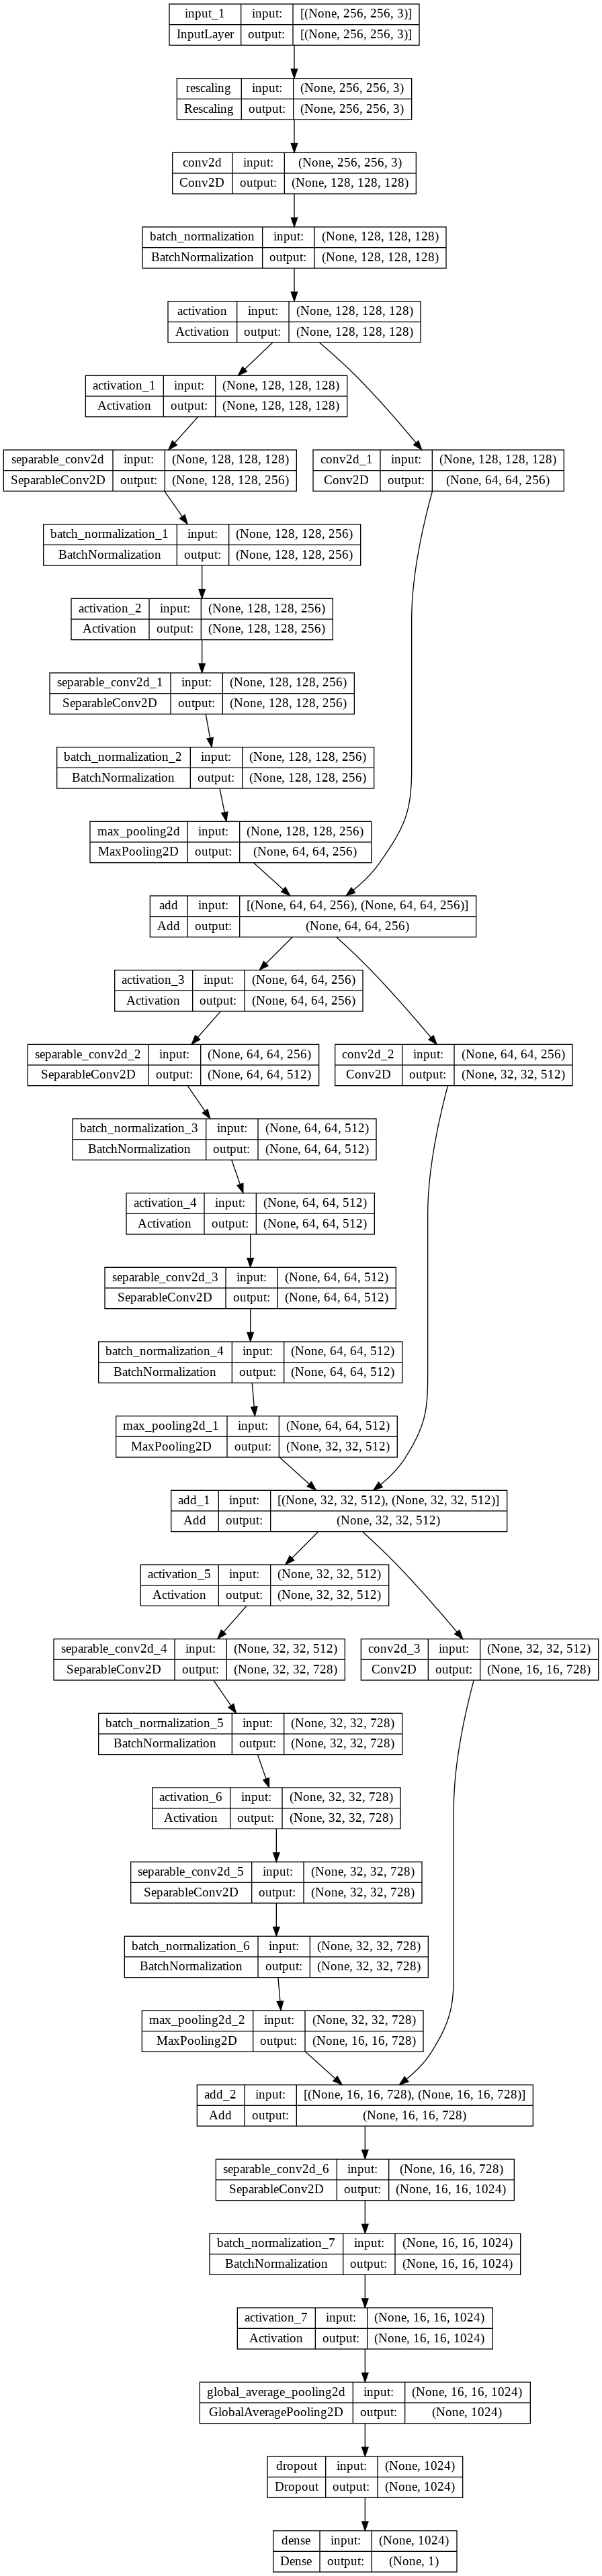

In [56]:
#example model 
import graphviz
from keras.utils.vis_utils import plot_model

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)
model = make_model(input_shape=image_size + (3,), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

In [1]:
epochs = 25

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

NameError: ignored